In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

In [2]:
load_path='E:/VA/onehandtwohand/128/106words_DSLR_FH/'
CATEGORIES=np.load(load_path+'cat_106.npy', allow_pickle=True)
IMG_SIZE=128
cat_len=len(CATEGORIES)
print(cat_len)
X=np.load(load_path+'X_dslr.npy', allow_pickle=True)
Y=np.load(load_path+'Y_dslr.npy', allow_pickle=True)
# X = X.astype('float32')
# X /= 255

106


In [3]:
Y_new=[]
for i in range(len(X)):
    index = (Y[i].tolist()).index(1)
    Y_new.append(index)
len(Y_new)

Y=np.array(Y_new)
print(Y.shape)

(43469,)


In [4]:
print('Splitting') 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = cat_len)
X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size = 0.2, random_state = cat_len)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_new = np.array(X_new)
y_new = np.array(y_new)

print("pass")
del X,Y

Splitting
pass


In [5]:
num_classes = cat_len
input_shape = (IMG_SIZE, IMG_SIZE, 3)
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 100
num_epochs = 75
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
# print('Image Data Augmentation')
# from keras.preprocessing.image import ImageDataGenerator
# val_generator = ImageDataGenerator(rotation_range=0, zoom_range=0.2, width_shift_range=0.2,
#     height_shift_range=0.2, shear_range=0.2, resize=(image_size, image_size,3))
# #                                     , horizontal_flip=True, brightness_range=[0.6,1.3])
# val_generator.fit(X_train)
# val_generator.fit(X_new)
# val_generator.fit(X_test)

# print("done")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


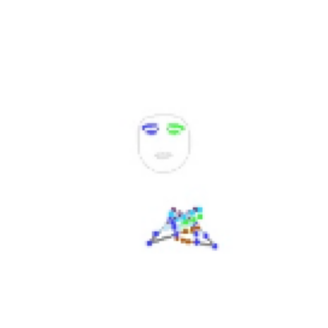

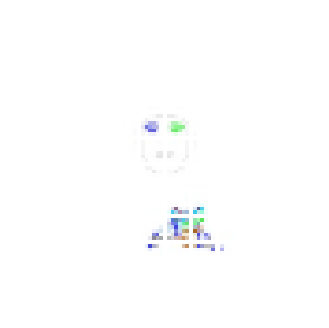

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow((image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [12]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [13]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = load_path+"tmp"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model, history


vit_classifier = create_vit_classifier()
model, history = run_experiment(vit_classifier)

Epoch 1/75
220/220 [==============================] - 329s 1s/step - loss: 4.8029 - accuracy: 0.0179 - top-5-accuracy: 0.0775 - val_loss: 4.3547 - val_accuracy: 0.0706 - val_top-5-accuracy: 0.2698
Epoch 2/75
220/220 [==============================] - 312s 1s/step - loss: 4.0725 - accuracy: 0.0704 - top-5-accuracy: 0.2377 - val_loss: 3.1990 - val_accuracy: 0.2637 - val_top-5-accuracy: 0.5405
Epoch 3/75
220/220 [==============================] - 311s 1s/step - loss: 3.3358 - accuracy: 0.1699 - top-5-accuracy: 0.4334 - val_loss: 2.4719 - val_accuracy: 0.4131 - val_top-5-accuracy: 0.7183
Epoch 4/75
220/220 [==============================] - 314s 1s/step - loss: 2.8910 - accuracy: 0.2434 - top-5-accuracy: 0.5476 - val_loss: 2.1228 - val_accuracy: 0.4460 - val_top-5-accuracy: 0.7766
Epoch 5/75
220/220 [==============================] - 313s 1s/step - loss: 2.5767 - accuracy: 0.3030 - top-5-accuracy: 0.6348 - val_loss: 1.7911 - val_accuracy: 0.5515 - val_top-5-accuracy: 0.8497
Epoch 6/75
220/

220/220 [==============================] - 307s 1s/step - loss: 0.1360 - accuracy: 0.9593 - top-5-accuracy: 0.9991 - val_loss: 0.1724 - val_accuracy: 0.9511 - val_top-5-accuracy: 0.9988
Epoch 50/75
220/220 [==============================] - 308s 1s/step - loss: 0.1365 - accuracy: 0.9599 - top-5-accuracy: 0.9988 - val_loss: 0.1892 - val_accuracy: 0.9335 - val_top-5-accuracy: 0.9984
Epoch 51/75
220/220 [==============================] - 307s 1s/step - loss: 0.1397 - accuracy: 0.9589 - top-5-accuracy: 0.9990 - val_loss: 0.1618 - val_accuracy: 0.9499 - val_top-5-accuracy: 0.9992
Epoch 52/75
220/220 [==============================] - 310s 1s/step - loss: 0.1359 - accuracy: 0.9592 - top-5-accuracy: 0.9989 - val_loss: 0.1545 - val_accuracy: 0.9536 - val_top-5-accuracy: 0.9984
Epoch 53/75
220/220 [==============================] - 309s 1s/step - loss: 0.1216 - accuracy: 0.9645 - top-5-accuracy: 0.9992 - val_loss: 0.1618 - val_accuracy: 0.9499 - val_top-5-accuracy: 0.9988
Epoch 54/75
220/220 [=

In [16]:
print('Saving')
model_name1 = 'VAViT'
np.save(load_path+model_name1+'_history.npy',history.history)
model.save(load_path+model_name1+'_model.sav') 
print("saved")

Saving


INFO:tensorflow:Assets written to: E:/VA/onehandtwohand/128/106words_DSLR_FH/VAViT_model.sav\assets


INFO:tensorflow:Assets written to: E:/VA/onehandtwohand/128/106words_DSLR_FH/VAViT_model.sav\assets


saved


In [ ]:
# #load saved history
model_name1 = 'VAViT'
history_const=np.load(load_path+model_name1+'_history.npy',allow_pickle='TRUE').item()

# #load saved model
model1=load_model(load_path+model_name1+'_model.sav')

print("loaded")

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model1.predict(X_new)

Y_pred=[]
for i in range(len(X_new)):
#     index = (y_pred[i].tolist()).index(argmax())
    index = y_pred[i].argmax()
    Y_pred.append(index)
Y_pred=np.array(Y_pred)

accuracy_score(y_new, Y_pred)